## Final Project Submission

Please fill out:
* Leah Pilossoph 
* Student pace: full time
* Scheduled project review date/time: 3/22/19 @ 3:00pm EST
* Instructor name: Rafael Carrasco
* Blog post URL: www.thedatarn.com


# SKIN LESION RISK IDENTIFICATION

# Table of Contents:
## <a href='#Part_1'> Obtaining the Data</a> 
## <a href='#Part_2'> Scrubbing the Data</a>   
## <a href='#Part_4'> Modeling the Data</a> 
## <a href='#Part_5'> Now, for the Final Model:)</a>
## <a href='#Part_6'> Conclusions</a>
## <a href='#Part_7'> Recommendations</a>
## <a href='#Part_8'> Future Work</a>

In [573]:
# Importing necessary libraries

import pandas as pd
import numpy as np
from glob import glob
import keras
from keras import backend as K
from keras.layers import Dropout
import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import optimizers
import os
from sklearn.utils import class_weight
from keras import layers
from keras import models
from keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.applications import MobileNet
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
%matplotlib inline

In [2]:
#creating directories
base_dir = 'base_dir'
os.mkdir(base_dir)
#training directory:
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)
#testing directory:
test_dir = os.path.join(base_dir, 'test_dir')
os.mkdir(test_dir)
#splitting training directory for bening/malignant images:
benign = os.path.join(train_dir, 'benign')
os.mkdir(benign)
malignant = os.path.join(train_dir, 'malignant')
os.mkdir(malignant)
benign = os.path.join(test_dir, 'benign')
#splitting testing directory for bening/malignant images:
os.mkdir(benign)
malignant = os.path.join(test_dir, 'malignant')
os.mkdir(malignant)

<a id='Part_1'></a>

# Obtaining our Data:

In [378]:
#importing the data
df = pd.read_csv('../dsc-4-final-project-online-ds-ft-112618/HAM10000_metadata.tab', delimiter='\t')

In [379]:
#inspecting the data
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


<a id='Part_2'></a>

# Scrubbing our Data:

In [380]:
#preparing separate dataframe to grouped by lesion to identify lesions w/multiple images
df1 = df.groupby('lesion_id').count()
df1 = df1[df1['image_id'] == 1]
df1.reset_index(inplace=True)
df1.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [381]:
#identifying and removing duplicates:
def duplicates(x):
    lesion_list = list(df1['lesion_id'])
    if x in lesion_list:
        return 'no_duplicates'
    else:
        return 'duplicate'
    
# create a new colum that is a copy of the lesion_id column
df['duplicate'] = df['lesion_id']
# apply the function to this new column
df['duplicate'] = df['duplicate'].apply(duplicates)
df = df[df['duplicate'] == 'no_duplicates']
df.shape

(5514, 8)

In [382]:
#classifying lesion types as benign vs malignant
df['dx'] = df['dx'].map({'nv': 'benign', 'bkl': 'benign', 'vasc': 'benign', 'df': 'benign', 'mel': 'malignant', 'bcc': 'malignant', 'akiec': 'malignant'})

In [383]:
#splitting the data for train/test
y = df['dx']
_, df_val = train_test_split(df, test_size=0.10, stratify=y)
df_val.shape

(552, 8)

In [384]:
df_val['dx'].value_counts()

benign       496
malignant     56
Name: dx, dtype: int64

In [385]:
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'
# identify train and val rows
# create a new colum that is a copy of the image_id column
df['train_or_val'] = df['image_id']
# apply the function to this new column
df['train_or_val'] = df['train_or_val'].apply(identify_val_rows)
# filter out train rows
df_train = df[df['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))

4962
552


In [386]:
df.set_index('image_id', inplace=True) #setting image id as the index

## Moving images into train/test directories

In [12]:
folder_1 = os.listdir('../dsc-4-final-project-online-ds-ft-112618/HAM10000_images_part_1/')
folder_2 = os.listdir('../dsc-4-final-project-online-ds-ft-112618/HAM10000_images_part_2/')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])

# Transfer the train images:
for image in train_list:
    fname = image + '.jpg'
    label = df.loc[image,'dx']
    if fname in folder_1:
        # source path to image
        src = os.path.join('../dsc-4-final-project-online-ds-ft-112618/HAM10000_images_part_1/', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    if fname in folder_2:
        # source path to image
        src = os.path.join('../dsc-4-final-project-online-ds-ft-112618/HAM10000_images_part_2/', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

#transfer the val images:        
for image in val_list:
    fname = image + '.jpg'
    label = df.loc[image,'dx']
    if fname in folder_1:
        # source path to image
        src = os.path.join('../dsc-4-final-project-online-ds-ft-112618/HAM10000_images_part_1/', fname)
        # destination path to image
        dst = os.path.join(test_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
    if fname in folder_2:
        # source path to image
        src = os.path.join('../dsc-4-final-project-online-ds-ft-112618/HAM10000_images_part_2/', fname)
        # destination path to image
        dst = os.path.join(test_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)     

<a id='Part_4'></a>

# Modeling our Data:

In [586]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=.10)
test_datagen = ImageDataGenerator(rescale=1./255)

In [587]:
train_generator = train_datagen.flow_from_directory(train_dir, subset= "training", shuffle=True,target_size=(150,150),batch_size=4466)

validation_generator = train_datagen.flow_from_directory(train_dir, subset="validation", shuffle=True,target_size=(150,150),batch_size=496)

test_generator = test_datagen.flow_from_directory(test_dir,target_size=(150,150), shuffle=False, batch_size=552)

Found 7616 images belonging to 2 classes.
Found 846 images belonging to 2 classes.
Found 552 images belonging to 2 classes.


In [588]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(validation_generator)

In [589]:
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

In [590]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

In [591]:
train_y1 = np.reshape(train_labels_final, (4466,1))
test_y1 = np.reshape(test_labels_final, (552,1))
val_y1 = np.reshape(val_labels_final, (496,1))

### Sanity Check:)

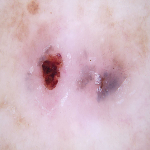

In [558]:
array_to_img(val_images[-2])

In [559]:
val_labels_final[:,-2]

array([1.], dtype=float32)

# Model 1: Built From Scratch

In [560]:
model1 = models.Sequential()
model1.add(layers.Dense(20, activation='relu', input_shape=(67500,), kernel_regularizer=regularizers.l2(0.005))) #2 hidden layers
model1.add(layers.Dense(7, activation='relu'))
model1.add(layers.Dense(5, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

In [561]:
model1.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.01), metrics=['accuracy'])

In [562]:
history1 = model1.fit(train_img,
                    train_y1,
                    epochs=50,
                    batch_size=202,
                    validation_data=(val_img, val_y1))

Train on 4466 samples, validate on 496 samples
Epoch 1/50
4466/4466 [==============================] - 18s 4ms/step - loss: 4.9042 - acc: 0.8652 - val_loss: 5.0985 - val_acc: 0.8992
Epoch 2/50
4466/4466 [==============================] - 1s 324us/step - loss: 3.6556 - acc: 0.8992 - val_loss: 2.3541 - val_acc: 0.8992
Epoch 3/50
4466/4466 [==============================] - 2s 343us/step - loss: 1.8793 - acc: 0.8992 - val_loss: 0.8788 - val_acc: 0.8992
Epoch 4/50
4466/4466 [==============================] - 1s 315us/step - loss: 2.1026 - acc: 0.8988 - val_loss: 1.4726 - val_acc: 0.8992
Epoch 5/50
4466/4466 [==============================] - 2s 337us/step - loss: 1.5390 - acc: 0.8992 - val_loss: 3.7634 - val_acc: 0.8992
Epoch 6/50
4466/4466 [==============================] - 1s 328us/step - loss: 1.9142 - acc: 0.8992 - val_loss: 0.5545 - val_acc: 0.8992
Epoch 7/50
4466/4466 [==============================] - 1s 320us/step - loss: 2.3635 - acc: 0.8992 - val_loss: 0.8884 - val_acc: 0.8992
Ep

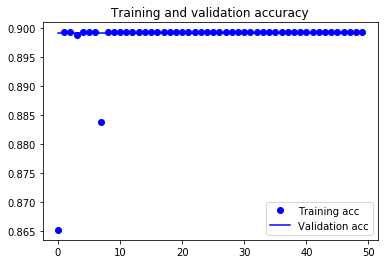

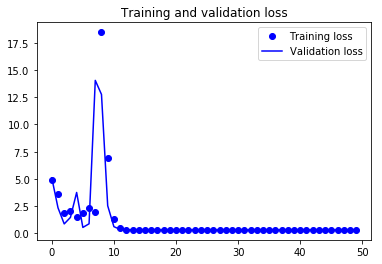

In [563]:
acc = history1.history['acc']
val_acc = history1.history['val_acc']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [564]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [565]:
test_loss, test_acc = model1.evaluate(test_img, test_y1)
print('test acc:', test_acc)
print('test loss:', test_loss)

552/552 [==============================] - 1s 1ms/step
test acc: 0.8985507246376812
test loss: 0.3282837949801182


In [566]:
y_class1 = model1.predict_classes(test_img, batch_size=1)

In [567]:
cm_plot_labels = ['benign', 'malignant']

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


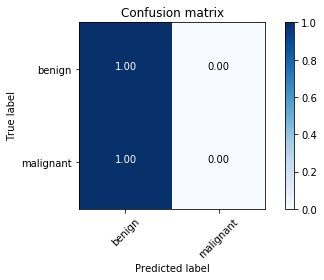

In [568]:
cm = confusion_matrix(test_y1, y_class1)

plot_confusion_matrix(cm, cm_plot_labels, normalize=True)

In [569]:
# predicting all benign - likely to due major class imbalance 

print("We have {} benign images in the train directory".format(len(os.listdir('../dsc-4-final-project-online-ds-ft-112618/base_dir/train_dir/benign/'))))
print("We have {} malignant images in the train directory".format(len(os.listdir('../dsc-4-final-project-online-ds-ft-112618/base_dir/train_dir/malignant/'))))
print("We have {} benign images in the test directory".format(len(os.listdir('../dsc-4-final-project-online-ds-ft-112618/base_dir/test_dir/benign/'))))
print("We have {} malignant images in the test directory".format(len(os.listdir('../dsc-4-final-project-online-ds-ft-112618/base_dir/test_dir/malignant/'))))

We have 4462 benign images in the train directory
We have 4000 malignant images in the train directory
We have 496 benign images in the test directory
We have 56 malignant images in the test directory


In [570]:
model1.save("model1.h5") #we'll save it even though its pretty useless

# Model 2: CNN Built from Scratch:

For this model we will use a Convolutional Neural network and add weights to handle class imbalance

In [574]:
class_weight = class_weight.compute_class_weight('balanced',np.unique(y), y)

In [575]:
class_weights = {0:class_weight[0], 1:class_weight[1]}
class_weights

{0: 0.5560709963695039, 1: 4.9586330935251794}

In [592]:
filepath="model2.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
callbacks_list = [checkpoint, stopping]

In [595]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1(0.005),
                        input_shape=(150 ,150,  3)))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(32, (4, 4), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['acc'])

model2.save('model2.h5')

In [598]:
history2 = model2.fit(train_images,
                    train_y1,
                    epochs=50,
                    batch_size=202,
                    validation_data=(val_images, val_y1), class_weight=class_weights, callbacks=callbacks_list)

Train on 4466 samples, validate on 496 samples
Epoch 1/50
4466/4466 [==============================] - 140s 31ms/step - loss: 1.0504 - acc: 0.5887 - val_loss: 0.9362 - val_acc: 0.8992

Epoch 00001: val_acc did not improve from 0.89919
Epoch 2/50
4466/4466 [==============================] - 132s 30ms/step - loss: 0.9330 - acc: 0.6290 - val_loss: 0.8447 - val_acc: 0.8992

Epoch 00002: val_acc did not improve from 0.89919
Epoch 3/50
4466/4466 [==============================] - 125s 28ms/step - loss: 0.8942 - acc: 0.3867 - val_loss: 0.8934 - val_acc: 0.1008

Epoch 00003: val_acc did not improve from 0.89919
Epoch 4/50
4466/4466 [==============================] - 133s 30ms/step - loss: 0.8623 - acc: 0.1008 - val_loss: 0.8530 - val_acc: 0.1008

Epoch 00004: val_acc did not improve from 0.89919
Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


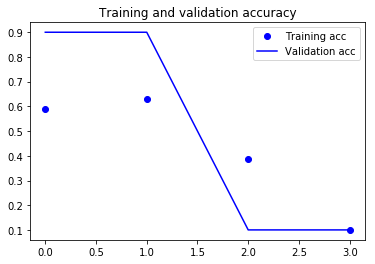

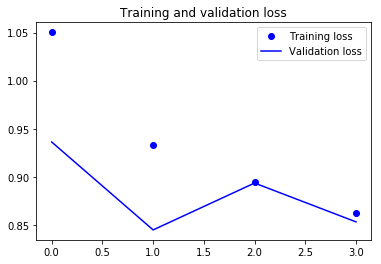

In [599]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [345]:
test_loss, test_acc = model2.evaluate(test_images, test_y1)
print('test acc:', test_acc)
print('test loss:', test_loss)

552/552 [==============================] - 4s 8ms/step
test acc: 0.802536231884058
test loss: 0.3523605163546576


In [346]:
y_pred = model2.predict_classes(test_images, batch_size=1)

Normalized confusion matrix
[[0.79637097 0.20362903]
 [0.14285714 0.85714286]]


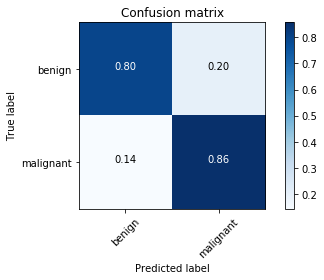

In [347]:
cm = confusion_matrix(test_y1, y_pred)

plot_confusion_matrix(cm, cm_plot_labels, normalize=True)

In [78]:
model2.save('model2.h5')

# Model 3: Using Pretrained Network MobileNetV2:

In [348]:
mobile = tensorflow.keras.applications.mobilenet_v2.MobileNetV2()
mobile.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [349]:
layer = mobile.layers[-1].output

# Create a new dense layer for predictions

layer = Dropout(0.2)(layer)
predictions = Dense(1, activation='sigmoid')(layer)

model3 = Model(inputs=mobile.input, outputs=predictions)
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

block_8_expand (Conv2D)         (None, 14, 14, 384)  24576       block_7_add[0][0]                
__________________________________________________________________________________________________
block_8_expand_BN (BatchNormali (None, 14, 14, 384)  1536        block_8_expand[0][0]             
__________________________________________________________________________________________________
block_8_expand_relu (ReLU)      (None, 14, 14, 384)  0           block_8_expand_BN[0][0]          
__________________________________________________________________________________________________
block_8_depthwise (DepthwiseCon (None, 14, 14, 384)  3456        block_8_expand_relu[0][0]        
__________________________________________________________________________________________________
block_8_depthwise_BN (BatchNorm (None, 14, 14, 384)  1536        block_8_depthwise[0][0]          
__________________________________________________________________________________________________
block_8_de

In [350]:
train_generator3 = train_datagen.flow_from_directory(train_dir, subset= "training",target_size=(224,224),batch_size=4466)

validation_generator3 = train_datagen.flow_from_directory(train_dir, subset="validation",target_size=(224,224),batch_size=496)

test_generator3 = test_datagen.flow_from_directory(test_dir, target_size=(224,224), shuffle=False, batch_size=552)

Found 7616 images belonging to 2 classes.
Found 846 images belonging to 2 classes.
Found 552 images belonging to 2 classes.


In [351]:
train_images3, train_labels3 = next(train_generator3)
test_images3, test_labels3 = next(test_generator3)
val_images3, val_labels3 = next(validation_generator3)

In [352]:
m_train3 = train_images3.shape[0]
num_px3 = train_images3.shape[1]
m_test3 = test_images3.shape[0]
m_val3 = val_images3.shape[0]

print ("Number of training samples: " + str(m_train3))
print ("Number of testing samples: " + str(m_test3))
print ("Number of validation samples: " + str(m_val3))
print ("train_images shape: " + str(train_images3.shape))
print ("train_labels shape: " + str(train_labels3.shape))
print ("test_images shape: " + str(test_images3.shape))
print ("test_labels shape: " + str(test_labels3.shape))
print ("val_images shape: " + str(val_images3.shape))
print ("val_labels shape: " + str(val_labels3.shape))

Number of training samples: 4466
Number of testing samples: 552
Number of validation samples: 496
train_images shape: (4466, 224, 224, 3)
train_labels shape: (4466, 2)
test_images shape: (552, 224, 224, 3)
test_labels shape: (552, 2)
val_images shape: (496, 224, 224, 3)
val_labels shape: (496, 2)


In [353]:
train_img3 = train_images3.reshape(train_images3.shape[0], -1)
test_img3 = test_images3.reshape(test_images3.shape[0], -1)
val_img3 = val_images3.reshape(val_images3.shape[0], -1)

print(train_img3.shape)
print(test_img3.shape)
print(val_img3.shape)

(4466, 150528)
(552, 150528)
(496, 150528)


In [354]:
train_y3 = np.reshape(train_labels3, (2, 4466))
test_y3 = np.reshape(test_labels3, (2, 552))
val_y3 = np.reshape(val_labels3, (2, 496))

In [355]:
train_labels_final3 = train_labels3.T[[1]]
test_labels_final3 = test_labels3.T[[1]]
val_labels_final3 = val_labels3.T[[1]]

In [356]:
print(train_labels_final3.shape)
print(test_labels_final3.shape)
print(val_labels_final3.shape)
print (train_y3.shape)
print (test_y3.shape)
print (val_y3.shape)

(1, 4466)
(1, 552)
(1, 496)
(2, 4466)
(2, 552)
(2, 496)


In [357]:
train_y3 = np.reshape(train_labels_final3, (4466,1))
test_y3 = np.reshape(test_labels_final3, (552,1))
val_y3 = np.reshape(val_labels_final3, (496,1))

In [358]:
#freezing layers
for layer in model3.layers[:-25]:
    layer.trainable = False
for layer in model3.layers:
    print(layer.name, layer.trainable)
print(len(model3.trainable_weights))

input_9 False
Conv1_pad False
Conv1 False
bn_Conv1 False
Conv1_relu False
expanded_conv_depthwise False
expanded_conv_depthwise_BN False
expanded_conv_depthwise_relu False
expanded_conv_project False
expanded_conv_project_BN False
block_1_expand False
block_1_expand_BN False
block_1_expand_relu False
block_1_pad False
block_1_depthwise False
block_1_depthwise_BN False
block_1_depthwise_relu False
block_1_project False
block_1_project_BN False
block_2_expand False
block_2_expand_BN False
block_2_expand_relu False
block_2_depthwise False
block_2_depthwise_BN False
block_2_depthwise_relu False
block_2_project False
block_2_project_BN False
block_2_add False
block_3_expand False
block_3_expand_BN False
block_3_expand_relu False
block_3_pad False
block_3_depthwise False
block_3_depthwise_BN False
block_3_depthwise_relu False
block_3_project False
block_3_project_BN False
block_4_expand False
block_4_expand_BN False
block_4_expand_relu False
block_4_depthwise False
block_4_depthwise_BN False

In [359]:
model3.save('model3.h5')

In [360]:
filepath="model3.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
callbacks_list = [checkpoint, stopping]

In [361]:
model3.compile(Adam(lr=0.001),loss='binary_crossentropy', metrics=['accuracy'])

In [362]:
history3 = model3.fit(train_images3, train_y3, 
                              class_weight=class_weights,
                    validation_data=(val_images3, val_y3), batch_size=202,
                    epochs=50, verbose=1, callbacks=callbacks_list)

Train on 4466 samples, validate on 496 samples
Epoch 1/50
4444/4466 [============================>.] - ETA: 1s - loss: 0.6566 - acc: 0.5950 
Epoch 00001: val_acc improved from -inf to 0.54234, saving model to model3.h5
4466/4466 [==============================] - 346s 77ms/sample - loss: 0.6565 - acc: 0.5961 - val_loss: 0.6912 - val_acc: 0.5423
Epoch 2/50
4444/4466 [============================>.] - ETA: 1s - loss: 0.6306 - acc: 0.8562 
Epoch 00002: val_acc improved from 0.54234 to 0.68548, saving model to model3.h5
4466/4466 [==============================] - 351s 79ms/sample - loss: 0.6305 - acc: 0.8567 - val_loss: 0.6788 - val_acc: 0.6855
Epoch 3/50
4444/4466 [============================>.] - ETA: 1s - loss: 0.6104 - acc: 0.8621 
Epoch 00003: val_acc improved from 0.68548 to 0.71169, saving model to model3.h5
4466/4466 [==============================] - 327s 73ms/sample - loss: 0.6103 - acc: 0.8621 - val_loss: 0.6674 - val_acc: 0.7117
Epoch 4/50
4444/4466 [=========================

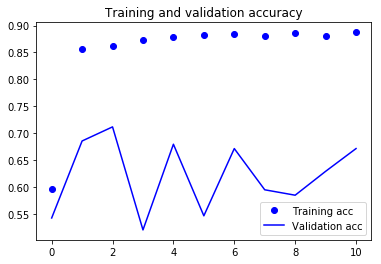

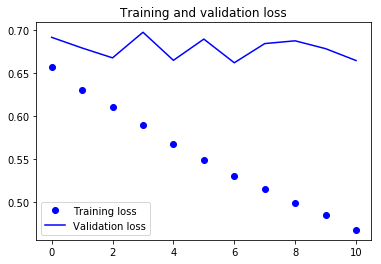

In [363]:
acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [148]:
model3.load_weights('model3.h5')

In [364]:
test_loss, test_acc = model3.evaluate(test_images3, test_y3)
print('test acc:', test_acc)
print('test loss:', test_loss)

552/552 [==============================] - 23s 42ms/sample - loss: 0.6614 - acc: 0.8333
test acc: 0.8333333
test loss: 0.6613880706870038


In [365]:
y_pred3 = model3.predict(test_images3, batch_size=1)

In [373]:
y_pred3 =(y_pred3>0.5)

Normalized confusion matrix
[[0.87096774 0.12903226]
 [0.5        0.5       ]]


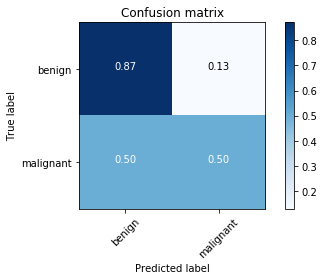

In [372]:
cm = confusion_matrix(test_y3, y_pred3)

plot_confusion_matrix(cm, cm_plot_labels, normalize=True)

# Model 4: Pretrained Model with Data Augmentation:

In [239]:
to_aug = ['malignant']

for item in to_aug:
    
    # creating temporary directories to delete later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item
    img_list = os.listdir('../dsc-4-final-project-online-ds-ft-112618/base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('../dsc-4-final-project-online-ds-ft-112618/base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = '../dsc-4-final-project-online-ds-ft-112618/base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=(0.9,1.1),
        fill_mode='nearest')
    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 4000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 4000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 500 images belonging to 1 classes.


In [610]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=.1)
test_datagen = ImageDataGenerator(rescale=1./255)

In [611]:
print(len(os.listdir('../dsc-4-final-project-online-ds-ft-112618/base_dir/train_dir/benign/')))
print(len(os.listdir('../dsc-4-final-project-online-ds-ft-112618/base_dir/train_dir/malignant/')))
print(len(os.listdir('../dsc-4-final-project-online-ds-ft-112618/base_dir/test_dir/benign/')))
print(len(os.listdir('../dsc-4-final-project-online-ds-ft-112618/base_dir/test_dir/malignant/')))

4462
4000
496
56


In [618]:
train_generator3 = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir, subset= "training", shuffle=True,
        # All images will be resized to 150x150
        target_size=(150,150),
        batch_size=7616)

validation_generator3 = train_datagen.flow_from_directory(
        train_dir, subset="validation", shuffle=True,
        target_size=(150,150),
        batch_size=846)
test_generator3 = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150,150), shuffle=False,
        batch_size=552)

Found 7616 images belonging to 2 classes.
Found 846 images belonging to 2 classes.
Found 552 images belonging to 2 classes.


In [619]:
train_images3, train_labels3 = next(train_generator3)
test_images3, test_labels3 = next(test_generator3)
val_images3, val_labels3 = next(validation_generator3)

In [620]:
m_train3 = train_images3.shape[0]
num_px3 = train_images3.shape[1]
m_test3 = test_images3.shape[0]
m_val3 = val_images3.shape[0]

print ("Number of training samples: " + str(m_train3))
print ("Number of testing samples: " + str(m_test3))
print ("Number of validation samples: " + str(m_val3))
print ("train_images shape: " + str(train_images3.shape))
print ("train_labels shape: " + str(train_labels3.shape))
print ("test_images shape: " + str(test_images3.shape))
print ("test_labels shape: " + str(test_labels3.shape))
print ("val_images shape: " + str(val_images3.shape))
print ("val_labels shape: " + str(val_labels3.shape))

Number of training samples: 7616
Number of testing samples: 552
Number of validation samples: 846
train_images shape: (7616, 150, 150, 3)
train_labels shape: (7616, 2)
test_images shape: (552, 150, 150, 3)
test_labels shape: (552, 2)
val_images shape: (846, 150, 150, 3)
val_labels shape: (846, 2)


In [621]:
train_img3 = train_images3.reshape(train_images3.shape[0], -1)
test_img3 = test_images3.reshape(test_images3.shape[0], -1)
val_img3 = val_images3.reshape(val_images3.shape[0], -1)

print(train_img3.shape)
print(test_img3.shape)
print(val_img3.shape)

(7616, 67500)
(552, 67500)
(846, 67500)


In [622]:
train_y3 = np.reshape(train_labels3, (2, 7616))
test_y3 = np.reshape(test_labels3, (2, 552))
val_y3 = np.reshape(val_labels3, (2, 846))

In [623]:
train_labels_final3 = train_labels3.T[[1]]
test_labels_final3 = test_labels3.T[[1]]
val_labels_final3 = val_labels3.T[[1]]

In [624]:
print(train_labels_final3.shape)
print(test_labels_final3.shape)
print(val_labels_final3.shape)
print (train_y3.shape)
print (test_y3.shape)
print (val_y3.shape)

(1, 7616)
(1, 552)
(1, 846)
(2, 7616)
(2, 552)
(2, 846)


In [625]:
train_y3 = np.reshape(train_labels_final3, (7616,1))
test_y3 = np.reshape(test_labels_final3, (552,1))
val_y3 = np.reshape(val_labels_final3, (846,1))

In [305]:
filepath="model4.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpoint, stopping]

In [308]:
model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005),
                        input_shape=(150 ,150,  3)))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(32, (4, 4), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Flatten())
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['acc'])

model4.save('model4.h5')

In [309]:
history4 = model4.fit(train_images3,
                    train_y3,
                    epochs=50,
                    batch_size=202,
                    validation_data=(val_images3, val_y3), callbacks=callbacks_list, class_weight=weights)

Train on 7616 samples, validate on 846 samples
Epoch 1/50
7616/7616 [==============================] - 226s 30ms/step - loss: 0.7454 - acc: 0.4988 - val_loss: 0.9354 - val_acc: 0.5047

Epoch 00001: val_acc improved from -inf to 0.50473, saving model to model4.h5
Epoch 2/50
7616/7616 [==============================] - 224s 29ms/step - loss: 0.5512 - acc: 0.6937 - val_loss: 0.7907 - val_acc: 0.7482

Epoch 00002: val_acc improved from 0.50473 to 0.74823, saving model to model4.h5
Epoch 3/50
7616/7616 [==============================] - 219s 29ms/step - loss: 0.4731 - acc: 0.7692 - val_loss: 0.4474 - val_acc: 0.8688

Epoch 00003: val_acc improved from 0.74823 to 0.86879, saving model to model4.h5
Epoch 4/50
7616/7616 [==============================] - 221s 29ms/step - loss: 0.4457 - acc: 0.7849 - val_loss: 0.4413 - val_acc: 0.8534

Epoch 00004: val_acc did not improve from 0.86879
Epoch 5/50
7616/7616 [==============================] - 224s 29ms/step - loss: 0.3919 - acc: 0.8107 - val_loss:

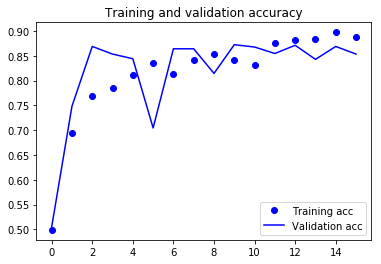

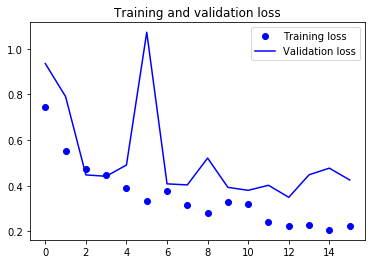

In [310]:
acc = history4.history['acc']
val_acc = history4.history['val_acc']
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [626]:
test_loss3, test_acc3 = model4.evaluate(test_images3, test_y3)

print('test acc:', test_acc3)
print('test loss:', test_loss3)

552/552 [==============================] - 6s 10ms/step
test acc: 0.7989130434782609
test loss: 0.4397424660299135


In [312]:
model4.load_weights('model4.h5')
test_loss3w, test_acc3w = model4.evaluate(test_images3, test_y3)

print('test acc:', test_acc3w)
print('test loss:', test_loss3w)

552/552 [==============================] - 6s 10ms/step
test acc: 0.7989130434782609
test loss: 0.4397424660299135


In [631]:
y_predcm = (y_pred3 > 0.5)

Normalized confusion matrix
[[0.78427419 0.21572581]
 [0.07142857 0.92857143]]


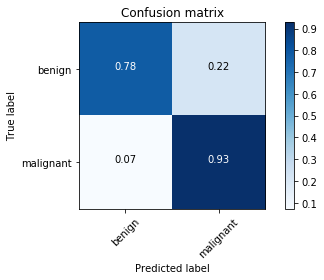

In [632]:
cm = confusion_matrix(test_y3, y_predcm)

plot_confusion_matrix(cm, cm_plot_labels, normalize=True)

Confusion matrix, without normalization
[[366 130]
 [  0  56]]


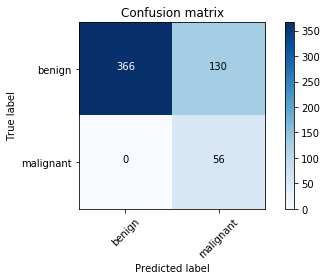

In [584]:
cm = confusion_matrix(test_y3, y_predcm)

plot_confusion_matrix(cm, cm_plot_labels)

In [597]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(test_y3, y_predcm, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

      benign       1.00      0.74      0.85       496
   malignant       0.30      1.00      0.46        56

   micro avg       0.76      0.76      0.76       552
   macro avg       0.65      0.87      0.66       552
weighted avg       0.93      0.76      0.81       552



### Recall = Given a malignant lesion, will the classifier be able to detect it?
### Precision = Given a prediction from the classifier, how likely is it to be correct?
### F1 Score = The harmonic mean of the recall and precision.

In [602]:
!pip install pydot

In [604]:
import pydot
from keras.utils import plot_model
plot_model(model4, to_file='model4.png')

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [338]:
images=glob("../dsc-4-final-project-online-ds-ft-112618/base_dir/test_dir/malignant/*.jpg")

In [339]:
for i in images:
    
    img = image.load_img(i, target_size=(255,255))
    img_tensor = image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.


In [340]:
to_classify = []
for i in images:
    img = image.load_img(i, target_size=(150,150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images3 = np.vstack([x])
    to_classify.append(images3)
final = np.concatenate(to_classify)

final.shape

(56, 150, 150, 3)

In [342]:
classes = model4.predict_classes(final, batch_size=56)
for c in classes:
    if c == 0:
        print("Predicted class is:",c)
        img_tensor = image.img_to_array(img)
        img_tensor = np.expand_dims(img_tensor, axis=0)
        img_tensor /= 255.
        plt.imshow(img_tensor[0])
        plt.show()
        print(img_tensor.shape)

<a id='Part_5'></a>

# Final Model! 

In [343]:
model4.save('model4.h5')

<a id='Part_6'></a>

# Conclusions:

* Malignant skin lesions can be detected with 76% accuracy and 100% Recall in order to guide clinical next steps (i.e. biopsy, invasive surgery, or no action at all)
* Cost saving can be achieved in the health care community with the utilization of this model combined with astute clinical judgement 
* A reduction in patient anxiety will also be seen as a result of fewer biopsies and stressful waiting periods for results

<a id='Part_7'></a>

# Recommendations:

* Improve model to include more images of skin lesions
* Seek to include more malignant images to improve class imbalance
* Secure funding for a study that submits additional photos and biopsy results to make the model more robust

<a id='Part_8'></a>

# Future Work:

* Design and implement study to include more images of biopsied lesions
* Consider the establishment of guidelines for skin biopsy with the utilization of image capturing 
* Continuous improvements to model as new information/data is obtained